In [1]:
import pandas as pd
import numpy as np
from numpy.random import (
    beta, binomial
)
import scipy.stats as stats
from IPython.display import display
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import plotly.express as px
import matplotlib.pyplot as plt
from scipy.stats import beta

/Users/lihanli/.virtualenvs/jupyter/lib/python3.7/site-packages/google/colab/data_table.py:30: UserWarning:

IPython.utils.traitlets has moved to a top-level traitlets package.



In [2]:
Batting = pd.read_csv('data/baseballdatabank-master/core/Batting.csv', index_col=['playerID'])
Pitching = pd.read_csv('data/baseballdatabank-master/core/Pitching.csv', index_col=['playerID'])
Master = pd.read_csv('data/baseballdatabank-master/core/Master.csv', index_col='playerID')

In [3]:
Batting = Batting[~Batting.index.isin(Pitching.index)]
career = (Batting[Batting["AB"] > 0]
            .groupby(level=0)
            .agg({
                'H': np.sum, 
                'AB': np.sum
            })
          .assign(average = lambda r: r['H'] / r['AB']))
career = career.join(Master).assign(name=lambda x: x['nameFirst'] + ' ' + x['nameLast'])[[
    'name', 'H', 'AB', 'average'
]]
career.head()

,name,H,AB,average
playerID,,,,
aaronha01,Hank Aaron,3771.0,12364.0,0.304998
aaronto01,Tommie Aaron,216.0,944.0,0.228814
abadan01,Andy Abad,2.0,21.0,0.095238
abadijo01,John Abadie,11.0,49.0,0.224490
abbated01,Ed Abbaticchio,772.0,3044.0,0.253614


In [4]:
# priors estimated in chapter 3
alpha0 = 75.88
beta0 = 216.69

career = career.assign(average_estimate=lambda x: (x['H'] + alpha0) / (x['AB'] + alpha0 + beta0))


In [5]:
career = career.assign(alpha1=lambda x: alpha0 + x['H'],
                       beta1=lambda x: beta0 + x['AB'] - x['H'])
career.head()

,name,H,AB,average,average_estimate,alpha1,beta1
playerID,,,,,,,
aaronha01,Hank Aaron,3771.0,12364.0,0.304998,0.303943,3846.88,8809.69
aaronto01,Tommie Aaron,216.0,944.0,0.228814,0.236040,291.88,944.69
abadan01,Andy Abad,2.0,21.0,0.095238,0.248366,77.88,235.69
abadijo01,John Abadie,11.0,49.0,0.224490,0.254355,86.88,254.69
abbated01,Ed Abbaticchio,772.0,3044.0,0.253614,0.254117,847.88,2488.69


In [21]:
def pbeta(q, shape1, shape2):
    
    return stats.beta.cdf(q,shape1, shape2)

# Posterior Error Probability
pep = pbeta(0.3, 3850, 8818)
pep

0.16905138608713258

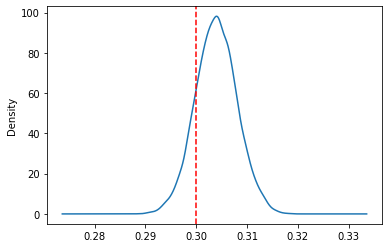

In [7]:
aaron = career.loc['aaronha01'].to_dict()
d = beta(aaron['alpha1'], aaron['beta1']).rvs(10000)
pd.Series(d).plot.kde()
plt.axvline(.3, color='r', linestyle='--')

In [8]:
career = career.assign(PEP= lambda df: df.apply(lambda x: pbeta(0.3, x['alpha1'], x['beta1']), axis=1))
career.head()

,name,H,AB,average,average_estimate,alpha1,beta1,PEP
playerID,,,,,,,,
aaronha01,Hank Aaron,3771.0,12364.0,0.304998,0.303943,3846.88,8809.69,0.16585
aaronto01,Tommie Aaron,216.0,944.0,0.228814,0.236040,291.88,944.69,1.00000
abadan01,Andy Abad,2.0,21.0,0.095238,0.248366,77.88,235.69,0.97970
abadijo01,John Abadie,11.0,49.0,0.224490,0.254355,86.88,254.69,0.97084
abbated01,Ed Abbaticchio,772.0,3044.0,0.253614,0.254117,847.88,2488.69,1.00000


In [9]:
fig = px.histogram(career, x="PEP", nbins=100)
fig.update_layout(
    xaxis_title_text='Posterior Error Probability (PEP)'
)
# fig.update_xaxes(range=[0.15, 0.375])
fig.show()

In [10]:
traces= [
    go.Scatter(x=career['average_estimate'], y=career['PEP'], mode='markers')
]
fig = go.Figure(traces)
fig.add_shape(type='line',
    x0=0.3, x1=0.3, y0=0, y1=1,
    line=dict(
        color="red",
        width=1,
        dash="dashdot",
    )
)
fig.show()

In [11]:
# False Discovery Rate

In [12]:
career = career.sort_values(['PEP', 'average_estimate'], ascending=[True, False])
career.head(10)

,name,H,AB,average,average_estimate,alpha1,beta1,PEP
playerID,,,,,,,,
hornsro01,Rogers Hornsby,2930.0,8173.0,0.358497,0.355071,3005.88,5459.69,0.0
jacksjo01,Shoeless Joe Jackson,1772.0,4981.0,0.355752,0.350404,1847.88,3425.69,0.0
delahed01,Ed Delahanty,2596.0,7505.0,0.345903,0.342655,2671.88,5125.69,0.0
hamilbi01,Billy Hamilton,2158.0,6268.0,0.344288,0.340501,2233.88,4326.69,0.0
heilmha01,Harry Heilmann,2660.0,7787.0,0.341595,0.338617,2735.88,5343.69,0.0
keelewi01,Willie Keeler,2932.0,8591.0,0.341287,0.338589,3007.88,5875.69,0.0
terrybi01,Bill Terry,2193.0,6428.0,0.341164,0.337602,2268.88,4451.69,0.0
gehrilo01,Lou Gehrig,2721.0,8001.0,0.340082,0.337235,2796.88,5496.69,0.0
gwynnto01,Tony Gwynn,3141.0,9288.0,0.338178,0.335771,3216.88,6363.69,0.0


In [13]:
career[90:100]

,name,H,AB,average,average_estimate,alpha1,beta1,PEP
playerID,,,,,,,,
mattido01,Don Mattingly,2153.0,7003.0,0.307440,0.305511,2228.88,5066.69,0.15327
vottojo01,Joey Votto,1226.0,3945.0,0.310773,0.307223,1301.88,2935.69,0.15384
wrighta01,Taffy Wright,1115.0,3583.0,0.311192,0.307279,1190.88,2684.69,0.16192
stonejo01,John Stone,1391.0,4494.0,0.309524,0.306457,1466.88,3319.69,0.16528
aaronha01,Hank Aaron,3771.0,12364.0,0.304998,0.303943,3846.88,8809.69,0.16585
canoro01,Robinson Cano,2015.0,6555.0,0.307399,0.305346,2090.88,4756.69,0.16947
morgaed01,Ed Morgan,879.0,2810.0,0.312811,0.307771,954.88,2147.69,0.17278
burnsge02,George Burns,2018.0,6573.0,0.307014,0.304983,2093.88,4771.69,0.18320
milleha01,Hack Miller,387.0,1200.0,0.322500,0.310123,462.88,1029.69,0.20002


In [14]:
career[:100].PEP.mean()

0.048303700000000005

In [15]:
career[:100].PEP.sum()

4.83037

In [16]:
career = career.assign(q_value = lambda df: df['PEP'].cumsum())
career.head()

,name,H,AB,average,average_estimate,alpha1,beta1,PEP,q_value
playerID,,,,,,,,,
hornsro01,Rogers Hornsby,2930.0,8173.0,0.358497,0.355071,3005.88,5459.69,0.0,0.0
jacksjo01,Shoeless Joe Jackson,1772.0,4981.0,0.355752,0.350404,1847.88,3425.69,0.0,0.0
delahed01,Ed Delahanty,2596.0,7505.0,0.345903,0.342655,2671.88,5125.69,0.0,0.0
hamilbi01,Billy Hamilton,2158.0,6268.0,0.344288,0.340501,2233.88,4326.69,0.0,0.0
heilmha01,Harry Heilmann,2660.0,7787.0,0.341595,0.338617,2735.88,5343.69,0.0,0.0


In [17]:
hall_of_fame = career[career['q_value'] < 0.05]
print(len(hall_of_fame))

48


In [18]:
career.reset_index()['q_value'].index

RangeIndex(start=0, stop=9429, step=1)

Text(0, 0.5, 'Number of players included at this threshold')

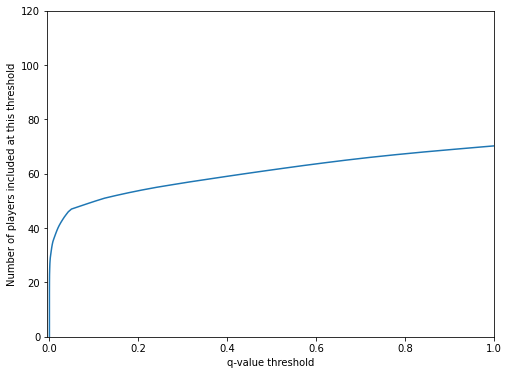

In [19]:
qvalues = career.reset_index()['q_value']

plt.figure(figsize=(8, 6))
plt.plot(qvalues.values, qvalues.index)
plt.xlim(-.005, 1)
plt.ylim(0, 120)
plt.xlabel('q-value threshold')
plt.ylabel('Number of players included at this threshold')